# How to use `fret_tester` to determine FRET kinetics

This is part of the `fret-tester` Python package.

For details, see the project [web page](https://github.com/schuetzgroup/fret-tester) and read the article
*Schrangl, Lukas; Göhring, Janett; Schütz,
  Gerhard J. (2018):
  “Kinetic analysis of single molecule FRET transitions without trajectories.”
  In: The Journal of Chemical Physics, 148 (2018), H. 12, p. 123328.*
  Available at: [DOI: 10.1063/1.5006038](https://doi.org/10.1063/1.5006038>).

## Preliminaries

Import Python packages, set up some variables, and load experiment data.

In [1]:
import os
from glob import glob

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

import fret_tester

In [2]:
data_dir = "tutorial_data"  # sample data

# For the donor brightness distributions, the standard deviation s was determined
# in a separate experiment as a function of the mean, s = 0.3 * m - 13.61
don_br = fret_tester.PolyLnBrightness([0.3, -13.61])
# For the acceptor, it is s = 0.3 * m - 1.92
acc_br = fret_tester.PolyLnBrightness([0.3, -1.92])

# Exposure times the smFRET experiments were conducted at
t_exp = [0.3, 3, 30]
# Time per frame to ensure that data points are not correlated
# If no prior information about state lifetimes is available, this can be
# guessed from preliminary experiments at different exposure times.
t_fr = 10
# Number of data points to simulate for each parameter combination
data_points = 10000

In [3]:
## Create simulated datasets in place of real experimental ones
true_lifetimes = [2, 4]
true_eff = [0.2, 0.8]
true_phot = 200
#
#tr = fret_tester.TwoStateExpTruth(true_lifetimes, true_eff)
#for t in t_exp:
#    d = fret_tester.simulate_dataset(tr, t, data_points, true_phot,
#                                     don_br, acc_br, t_fr)
#    np.savez_compressed(os.path.join(data_dir, "{:04.1f}ms.npz".format(t)),
#                        **d._asdict())

In [4]:
# Load experimental data (simulated in the cell above)

# For each exposure time, this will hold the list of measured single
# molecule FRET efficiencies
exp_eff = {}
# For each exposure time, this will hold the mean photon number
photons = {}
for t in t_exp:
    with np.load(os.path.join(data_dir, "{:04.1f}ms.npz".format(t))) as d:
        don = d["exp_don"]  # donor brightness for each fluorophore
        acc = d["exp_acc"]  # acceptor brightness for each fluorophore
        exp_eff[t] = acc / (don + acc)  # FRET efficiencies
        photons[t] = np.mean(don + acc)  # Mean total number of photons

smFRET efficiency distributions:

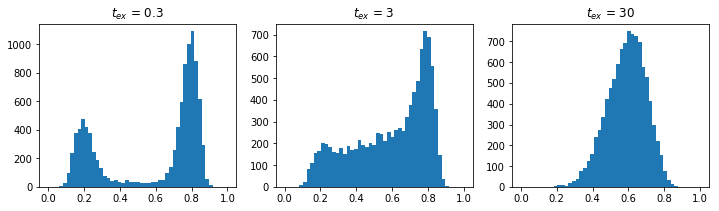

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for a, (t, e) in zip(ax, exp_eff.items()):
    a.hist(e, bins=np.linspace(0, 1, 50))
    a.set_title("$t_{{ex}}$ = {}".format(t))

In [6]:
# To find out about mean FRET efficiencies, fit a mixture of beta functions
# at the shortest exposure time
p, par1, par2 = fret_tester.bi_beta_fit(exp_eff[0.3], 100)
mean_eff = [stats.beta.mean(*par1), stats.beta.mean(*par2)]
print("Mean FRET efficiencies: E1 = {:.2f}, E2 = {:.2f}".format(*mean_eff))

Mean FRET efficiencies: E1 = 0.21, E2 = 0.79


## Run the analyis

In [7]:
# For the simulations, test the lifetime of states 1 and 2 both
# in the range between 1 and 10 in 50 logarithmic steps
test_times1 = test_times2 = np.logspace(0, 1, 50)
# Create a meshgrid to test all combinations of lifetimes
tt = np.meshgrid(test_times1, test_times2, indexing="ij")

p_val = {}  # This will hold the p-value array at different exposure times
for t in t_exp:
    p_val[t] = fret_tester.batch_test(
        tt, mean_eff, t, data_points, photons[t], exp_eff[t], don_br, acc_br)

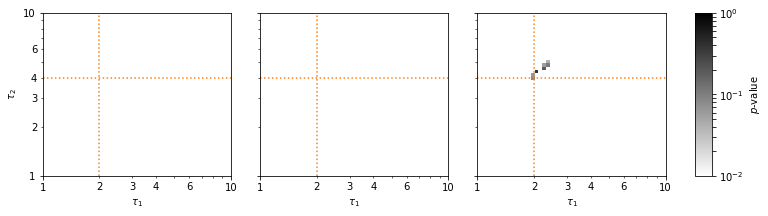

In [8]:
# Plot results
fig = plt.figure(figsize=(12, 3))
pl = fret_tester.Plotter2D()
pl.plot_series([[test_times1, test_times2]]*len(t_exp),
                [p_val[t] for t in t_exp],
                truths=[true_lifetimes]*len(t_exp));

This did not work.

The method is rather sensitive to the mean FRET efficiency input parameter to the simulations and the efficiencies determined by fitting the histogram is bound to overestimate the lower and underestimate the upper efficiency. Therefore try again with the lower value reduced and the upper value increased by 1%.

In [9]:
mean_eff_corr = [mean_eff[0] - 0.01, mean_eff[1] + 0.01]
p_val_corr = {}
for t in t_exp:
    p_val_corr[t] = fret_tester.batch_test(
        tt, mean_eff_corr, t, data_points, photons[t], exp_eff[t], don_br, acc_br)

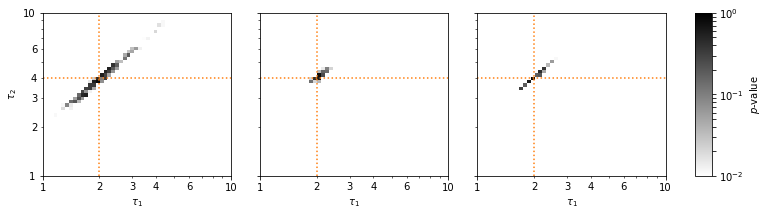

In [10]:
fig = plt.figure(figsize=(12, 3))
pl = fret_tester.Plotter2D()
pl.plot_series([[test_times1, test_times2]]*len(t_exp),
                [p_val_corr[t] for t in t_exp],
                truths=[true_lifetimes]*len(t_exp));